# Example of the mlexplorer() function 

Author: Charles Le Losq

**The `rampy.mlexplorer` class allows to explore sets of spectroscopic data with using principal component analysis or non-negative matrix factorization for instance.

It performs automatic data scaling and provides access to popular data mining algorithms from scikit-learn.

In [29]:
%matplotlib inline
import numpy as np
np.random.seed(42) # fixing the seed
import matplotlib
import matplotlib.pyplot as plt
import rampy as rp
from scipy.stats import norm

from sklearn.decomposition import PCA, NMF
import sklearn

In [45]:
class mlexplorer:
    """use machine learning algorithms from scikit learn to explore spectroscopic datasets


    Attributes
    ----------
    x : {array-like, sparse matrix}, shape = (n_samples, n_features)
        Spectra; n_features = n_frequencies.
    X_test : {array-like, sparse matrix}, shape = (n_samples, n_features)
        spectra organised in rows (1 row = one spectrum) that you want to use as a testing dataset. THose spectra should not be present in the x (training) dataset. The spectra should share a common X axis.
    algorithm : String,
        "PCA", "NMF", default = "PCA"
    scaling : Bool
        True or False. If True, data will be scaled prior to fitting (see below),
    scaler : String
        the type of scaling performed. Choose between MinMaxScaler or StandardScaler, see http://scikit-learn.org/stable/modules/preprocessing.html for details. Default = "MinMaxScaler".
    test_size : float
        the fraction of the dataset to use as a testing dataset; only used if X_test and y_test are not provided.
    rand_state : Float64
        the random seed that is used for reproductibility of the results. Default = 42.
    model : Scikit learn model
        A Scikit Learn object model, see scikit learn library documentation.
    X_scaler :
        A Scikit Learn scaler object for the x values.
    Y_scaler :
        A Scikit Learn scaler object for the y values.

    Remarks
    -------

    For details on hyperparameters of each algorithms, please directly consult the documentation of SciKit Learn at:

    http://scikit-learn.org/stable/

    Results for machine learning algorithms can vary from run to run. A way to solve that is to fix the random_state. 
    
    """

    def __init__(self,x,**kwargs):
        """
        Parameters
        ----------
        x : array{Float64}
            the spectra organised in rows (1 row = one spectrum). The spectra should share a common X axis.
        """
        self.x = x
        #
        # Kwargs extractions
        #
        self.X_test = kwargs.get("X_test",[0.0])
        self.algorithm = kwargs.get("algorithm","PCA")
        self.test_sz = kwargs.get("test_size",0.3)
        self.scaling = kwargs.get("scaling",True)
        self.scaler = kwargs.get("scaler","MinMaxScaler")
        self.rand_state = kwargs.get("rand_state",42)
        self.nb_compo = kwargs.get("n_components",None)

        # hyperparameters for the algorithms
        #self.user_kernel = kwargs.get("kernel","rbf")
        #self.param_kr = kwargs.get(
        #    "param_kr",dict(alpha=[1e1, 1e0, 0.5, 0.1, 5e-2, 1e-2, 5e-3, 1e-3],gamma=np.logspace(-4, 4, 9)))

        #self.param_svm= kwargs.get(
        #    "param_svm",dict(C= [1e0, 2e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5], gamma= np.logspace(-4, 4, 9)))

        if len(self.X_test) == 1:
            self.X_train, self.X_test = sklearn.model_selection.train_test_split(
            self.x, test_size=self.test_sz, random_state=self.rand_state)
        elif self.X_test.shape[1] == self.x.shape[1]:
            self.X_train = np.copy(self.x)
        else:
            ValueError("You tried to provide a testing dataset that has a different number of features (in columns) than the training set. Please correct this.")

        # initialising the preprocessor scaler
        if self.scaler == "StandardScaler":
            self.X_scaler = sklearn.preprocessing.StandardScaler()
        elif self.scaler == "MinMaxScaler":
            self.X_scaler = sklearn.preprocessing.MinMaxScaler()
        else:
            InputError("Choose the scaler between MinMaxScaler and StandardScaler")

    def fit(self):
        """Train the model with the indicated algorithm.

        Do not forget to tune the hyperparameters.

        Parameters
        ----------
        algorithm : String,
            "PCA", "NMF", default = "PCA"

        """
        self.X_scaler.fit(self.X_train)
        
        # scaling the data in all cases, it may not be used during the fit later
        self.X_train_sc = self.X_scaler.transform(self.X_train)
        
        self.X_test_sc = self.X_scaler.transform(self.X_test)
        
        if self.algorithm == "PCA":            
            self.model = PCA(n_components=self.nb_compo)

        elif self.algorithm == "NMF":
            self.model = NMF(n_components=self.nb_compo)
            
        if self.scaling == True:
            self.model.fit(self.X_train_sc)
        else:
            self.model.fit(self.X_train)

    def predict(self,X):
        """Predict using the model.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = (n_samples, n_features)
            Samples.

        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.

        Remark
        ------
        if self.scaling == "yes", scaling will be performed on the input X.
        """
        if self.scaling == True:
            X_sc = self.X_scaler.transform(X)
            pred_sc = self.model.predict(X_sc)
            return self.Y_scaler.inverse_transform(pred_sc.reshape(-1,1))
        else:
            return self.model.predict(self.X)


Number of samples:100
Shape of partial spectra matrix:(2, 600)
Shape of concentration matrix:(100, 2)


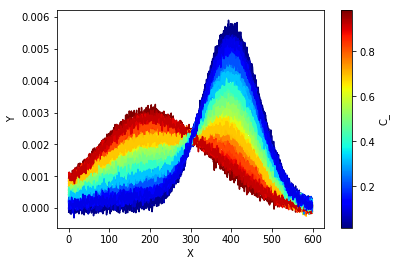

In [46]:
x = np.arange(0,600,1.0)
nb_samples = 100 # number of samples in our dataset

S_1 = norm.pdf(x,loc=200.,scale=130.)
S_2 = norm.pdf(x,loc=400,scale=70)
S_true = np.vstack((S_1,S_2))
print("Number of samples:"+str(nb_samples))
print("Shape of partial spectra matrix:"+str(S_true.shape))

C_ = np.random.rand(nb_samples) #60 samples with random concentrations between 0 and 1
C_true = np.vstack((C_,(1-C_))).T
print("Shape of concentration matrix:"+str(C_true.shape))

Obs = np.dot(C_true,S_true) + np.random.randn(nb_samples,len(x))*1e-4

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm_ = matplotlib.colors.Normalize(
    vmin=np.min(C_),
    vmax=np.max(C_))

# choose a colormap
c_m = matplotlib.cm.jet

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm_)
s_m.set_array([])

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(C_.shape[0]):
    plt.plot(x,
             Obs[i,:].T,
             color=s_m.to_rgba(C_[i]))

# we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m)
c_bar.set_label(r"C_")

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [47]:
explo = mlexplorer(Obs)

In [48]:
explo.algorithm = 'NMF'

In [49]:
explo.fit()

In [ ]:
W = explo.model.transform(Obs)
H = explo.model.components_

In [42]:
explo.model

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)